## Ref.
[Icing on the Cake: An Easy and Quick Post-Learnig Method You Can Try After Deep Learning, Konno, T. ,(2018)](https://arxiv.org/abs/1807.06540)  

> Step-1: Train a deep neural network as usual.  
> Step-2: Extract features from the layer just before the final classifier as estimation.  
> Step-3: Train only the final layer again by the extracted features.  
> Step-4: Put the final classifier back to the original network.  

From my understanding, this might be equivalent to training the model up to convergence and continuing the training with **frozen CNN** (i.e. train only the classifier.).

In [1]:
!nvidia-smi

Wed May  6 06:21:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [0]:
class ConvNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 3),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 32, 3),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2)
    )
    self.conv2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, 3),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64,64,3),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2)
    )
    self.conv3 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, 3),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128,128,3),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.Flatten()
      )    
    self.fc = torch.nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc(x)
    return x

net = ConvNet()

In [4]:
num_epochs = 50

train_transform = torchvision.transforms.Compose([
                                          # torchvision.transforms.RandomHorizontalFlip(0.5),
                                          # torchvision.transforms.RandomResizedCrop((32,32)),
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
test_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_size=128
num_workers = 4
lr = 1e-3

net = ConvNet()

train_ds = torchvision.datasets.CIFAR10('.', train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.CIFAR10('.', train=False, transform=test_transform, download=True)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=num_workers)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

net = net.to(device)


hist_dict = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[]
}

for epoch in range(1,num_epochs+1):  
  epoch_imgs, epoch_loss, epoch_corr = 0., 0., 0.
  for (data, labels) in tqdm.tqdm(train_dl):
    data, labels = data.to(device), labels.to(device)
    epoch_imgs += data.size(0)

    optimizer.zero_grad()
    outputs = net(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()*data.size(0)
    epoch_corr += sum(outputs.argmax(1) == labels).item()

  l = epoch_loss / epoch_imgs
  a = epoch_corr /epoch_imgs

  hist_dict['loss'].append(l)
  hist_dict['acc'].append(a)

  print('Epoch {}: Loss: {:.4f} Acc: {:.4f}'.format(epoch, l, a))

  val_imgs, val_loss, val_corr = 0., 0., 0.
  for (data, labels) in test_dl:
    data, labels = data.to(device), labels.to(device)
    val_imgs += data.size(0)

    with torch.no_grad():
      outputs = net(data)
      loss = criterion(outputs, labels)

    val_loss += loss.item()*data.size(0)
    val_corr += sum(outputs.argmax(1) == labels).item()

  l = val_loss / val_imgs
  a = val_corr /val_imgs

  hist_dict['val_loss'].append(l)
  hist_dict['val_acc'].append(a)

  print('Val {}: Loss: {:.4f} Acc: {:.4f}'.format(epoch, l, a))


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [00:10<00:00, 35.84it/s]

Epoch 1: Loss: 1.1762 Acc: 0.5789



  0%|          | 0/391 [00:00<?, ?it/s]

Val 1: Loss: 0.9046 Acc: 0.6804


100%|██████████| 391/391 [00:10<00:00, 36.50it/s]

Epoch 2: Loss: 0.7840 Acc: 0.7258



  0%|          | 0/391 [00:00<?, ?it/s]

Val 2: Loss: 0.7569 Acc: 0.7346


100%|██████████| 391/391 [00:10<00:00, 36.57it/s]

Epoch 3: Loss: 0.6344 Acc: 0.7765



  0%|          | 0/391 [00:00<?, ?it/s]

Val 3: Loss: 0.6989 Acc: 0.7578


100%|██████████| 391/391 [00:10<00:00, 36.38it/s]

Epoch 4: Loss: 0.5322 Acc: 0.8147



  0%|          | 0/391 [00:00<?, ?it/s]

Val 4: Loss: 0.6424 Acc: 0.7795


100%|██████████| 391/391 [00:10<00:00, 36.58it/s]

Epoch 5: Loss: 0.4487 Acc: 0.8439



  0%|          | 0/391 [00:00<?, ?it/s]

Val 5: Loss: 0.6384 Acc: 0.7823


100%|██████████| 391/391 [00:10<00:00, 36.63it/s]

Epoch 6: Loss: 0.3761 Acc: 0.8686



  0%|          | 0/391 [00:00<?, ?it/s]

Val 6: Loss: 0.6307 Acc: 0.7897


100%|██████████| 391/391 [00:10<00:00, 36.15it/s]

Epoch 7: Loss: 0.3140 Acc: 0.8902



  0%|          | 0/391 [00:00<?, ?it/s]

Val 7: Loss: 0.6445 Acc: 0.7912


100%|██████████| 391/391 [00:10<00:00, 36.86it/s]

Epoch 8: Loss: 0.2580 Acc: 0.9093



  0%|          | 0/391 [00:00<?, ?it/s]

Val 8: Loss: 0.6664 Acc: 0.7955


100%|██████████| 391/391 [00:10<00:00, 37.08it/s]

Epoch 9: Loss: 0.2120 Acc: 0.9261



  0%|          | 0/391 [00:00<?, ?it/s]

Val 9: Loss: 0.7102 Acc: 0.7894


100%|██████████| 391/391 [00:10<00:00, 36.69it/s]

Epoch 10: Loss: 0.1765 Acc: 0.9391



  0%|          | 0/391 [00:00<?, ?it/s]

Val 10: Loss: 0.7547 Acc: 0.7897


100%|██████████| 391/391 [00:10<00:00, 36.56it/s]

Epoch 11: Loss: 0.1495 Acc: 0.9473



  0%|          | 0/391 [00:00<?, ?it/s]

Val 11: Loss: 0.7761 Acc: 0.7913


100%|██████████| 391/391 [00:10<00:00, 36.40it/s]

Epoch 12: Loss: 0.1183 Acc: 0.9584



  0%|          | 0/391 [00:00<?, ?it/s]

Val 12: Loss: 0.8260 Acc: 0.7832


100%|██████████| 391/391 [00:10<00:00, 36.13it/s]

Epoch 13: Loss: 0.1003 Acc: 0.9648



  0%|          | 0/391 [00:00<?, ?it/s]

Val 13: Loss: 0.8674 Acc: 0.7886


100%|██████████| 391/391 [00:10<00:00, 36.02it/s]

Epoch 14: Loss: 0.0909 Acc: 0.9695



  0%|          | 0/391 [00:00<?, ?it/s]

Val 14: Loss: 0.8889 Acc: 0.7883


100%|██████████| 391/391 [00:10<00:00, 35.88it/s]

Epoch 15: Loss: 0.0872 Acc: 0.9704



  0%|          | 0/391 [00:00<?, ?it/s]

Val 15: Loss: 0.9536 Acc: 0.7869


100%|██████████| 391/391 [00:10<00:00, 35.71it/s]

Epoch 16: Loss: 0.0763 Acc: 0.9740



  0%|          | 0/391 [00:00<?, ?it/s]

Val 16: Loss: 0.9687 Acc: 0.7858


100%|██████████| 391/391 [00:10<00:00, 36.17it/s]

Epoch 17: Loss: 0.0667 Acc: 0.9773



  0%|          | 0/391 [00:00<?, ?it/s]

Val 17: Loss: 0.9933 Acc: 0.7813


100%|██████████| 391/391 [00:10<00:00, 36.17it/s]

Epoch 18: Loss: 0.0687 Acc: 0.9756



  0%|          | 0/391 [00:00<?, ?it/s]

Val 18: Loss: 0.9955 Acc: 0.7844


100%|██████████| 391/391 [00:10<00:00, 35.94it/s]

Epoch 19: Loss: 0.0598 Acc: 0.9799



  0%|          | 0/391 [00:00<?, ?it/s]

Val 19: Loss: 1.0156 Acc: 0.7849


100%|██████████| 391/391 [00:11<00:00, 35.42it/s]

Epoch 20: Loss: 0.0616 Acc: 0.9792



  0%|          | 0/391 [00:00<?, ?it/s]

Val 20: Loss: 1.0327 Acc: 0.7860


100%|██████████| 391/391 [00:11<00:00, 33.73it/s]

Epoch 21: Loss: 0.0570 Acc: 0.9798



  0%|          | 0/391 [00:00<?, ?it/s]

Val 21: Loss: 1.0147 Acc: 0.7861


100%|██████████| 391/391 [00:11<00:00, 33.35it/s]

Epoch 22: Loss: 0.0502 Acc: 0.9832



  0%|          | 0/391 [00:00<?, ?it/s]

Val 22: Loss: 1.0467 Acc: 0.7898


100%|██████████| 391/391 [00:11<00:00, 34.16it/s]

Epoch 23: Loss: 0.0462 Acc: 0.9848



  0%|          | 0/391 [00:00<?, ?it/s]

Val 23: Loss: 1.0482 Acc: 0.7912


100%|██████████| 391/391 [00:10<00:00, 35.64it/s]

Epoch 24: Loss: 0.0529 Acc: 0.9807



  0%|          | 0/391 [00:00<?, ?it/s]

Val 24: Loss: 1.1311 Acc: 0.7784


100%|██████████| 391/391 [00:10<00:00, 36.22it/s]

Epoch 25: Loss: 0.0461 Acc: 0.9842



  0%|          | 0/391 [00:00<?, ?it/s]

Val 25: Loss: 1.0906 Acc: 0.7857


100%|██████████| 391/391 [00:11<00:00, 35.39it/s]

Epoch 26: Loss: 0.0392 Acc: 0.9870



  0%|          | 0/391 [00:00<?, ?it/s]

Val 26: Loss: 1.1464 Acc: 0.7822


100%|██████████| 391/391 [00:10<00:00, 36.14it/s]

Epoch 27: Loss: 0.0385 Acc: 0.9869



  0%|          | 0/391 [00:00<?, ?it/s]

Val 27: Loss: 1.1393 Acc: 0.7837


100%|██████████| 391/391 [00:10<00:00, 36.26it/s]

Epoch 28: Loss: 0.0395 Acc: 0.9867



  0%|          | 0/391 [00:00<?, ?it/s]

Val 28: Loss: 1.1541 Acc: 0.7918


100%|██████████| 391/391 [00:10<00:00, 35.95it/s]

Epoch 29: Loss: 0.0454 Acc: 0.9844



  0%|          | 0/391 [00:00<?, ?it/s]

Val 29: Loss: 1.1385 Acc: 0.7882


100%|██████████| 391/391 [00:10<00:00, 36.07it/s]

Epoch 30: Loss: 0.0300 Acc: 0.9904



  0%|          | 0/391 [00:00<?, ?it/s]

Val 30: Loss: 1.1938 Acc: 0.7855


100%|██████████| 391/391 [00:10<00:00, 36.31it/s]

Epoch 31: Loss: 0.0381 Acc: 0.9866



  0%|          | 0/391 [00:00<?, ?it/s]

Val 31: Loss: 1.2127 Acc: 0.7821


100%|██████████| 391/391 [00:10<00:00, 35.59it/s]

Epoch 32: Loss: 0.0366 Acc: 0.9875



  0%|          | 0/391 [00:00<?, ?it/s]

Val 32: Loss: 1.1854 Acc: 0.7842


100%|██████████| 391/391 [00:10<00:00, 35.81it/s]

Epoch 33: Loss: 0.0284 Acc: 0.9899



  0%|          | 0/391 [00:00<?, ?it/s]

Val 33: Loss: 1.2037 Acc: 0.7898


100%|██████████| 391/391 [00:10<00:00, 36.36it/s]

Epoch 34: Loss: 0.0344 Acc: 0.9881



  0%|          | 0/391 [00:00<?, ?it/s]

Val 34: Loss: 1.2490 Acc: 0.7836


100%|██████████| 391/391 [00:10<00:00, 36.29it/s]

Epoch 35: Loss: 0.0382 Acc: 0.9871



  0%|          | 0/391 [00:00<?, ?it/s]

Val 35: Loss: 1.1940 Acc: 0.7908


100%|██████████| 391/391 [00:10<00:00, 35.91it/s]

Epoch 36: Loss: 0.0343 Acc: 0.9884



  0%|          | 0/391 [00:00<?, ?it/s]

Val 36: Loss: 1.2259 Acc: 0.7861


100%|██████████| 391/391 [00:10<00:00, 35.87it/s]

Epoch 37: Loss: 0.0252 Acc: 0.9920



  0%|          | 0/391 [00:00<?, ?it/s]

Val 37: Loss: 1.2061 Acc: 0.7916


100%|██████████| 391/391 [00:10<00:00, 35.82it/s]

Epoch 38: Loss: 0.0222 Acc: 0.9926



  0%|          | 0/391 [00:00<?, ?it/s]

Val 38: Loss: 1.2768 Acc: 0.7870


100%|██████████| 391/391 [00:11<00:00, 35.44it/s]

Epoch 39: Loss: 0.0340 Acc: 0.9885



  0%|          | 0/391 [00:00<?, ?it/s]

Val 39: Loss: 1.2422 Acc: 0.7917


100%|██████████| 391/391 [00:11<00:00, 35.08it/s]

Epoch 40: Loss: 0.0325 Acc: 0.9884



  0%|          | 0/391 [00:00<?, ?it/s]

Val 40: Loss: 1.2609 Acc: 0.7893


100%|██████████| 391/391 [00:10<00:00, 36.20it/s]

Epoch 41: Loss: 0.0308 Acc: 0.9895



  0%|          | 0/391 [00:00<?, ?it/s]

Val 41: Loss: 1.2753 Acc: 0.7850


100%|██████████| 391/391 [00:11<00:00, 35.44it/s]

Epoch 42: Loss: 0.0280 Acc: 0.9902



  0%|          | 0/391 [00:00<?, ?it/s]

Val 42: Loss: 1.2822 Acc: 0.7895


100%|██████████| 391/391 [00:10<00:00, 35.99it/s]

Epoch 43: Loss: 0.0217 Acc: 0.9929



  0%|          | 0/391 [00:00<?, ?it/s]

Val 43: Loss: 1.2951 Acc: 0.7837


100%|██████████| 391/391 [00:10<00:00, 35.93it/s]


Epoch 44: Loss: 0.0245 Acc: 0.9917


  0%|          | 0/391 [00:00<?, ?it/s]

Val 44: Loss: 1.3101 Acc: 0.7850


100%|██████████| 391/391 [00:11<00:00, 35.26it/s]

Epoch 45: Loss: 0.0248 Acc: 0.9915



  0%|          | 0/391 [00:00<?, ?it/s]

Val 45: Loss: 1.3119 Acc: 0.7842


100%|██████████| 391/391 [00:10<00:00, 35.83it/s]

Epoch 46: Loss: 0.0261 Acc: 0.9916



  0%|          | 0/391 [00:00<?, ?it/s]

Val 46: Loss: 1.3249 Acc: 0.7884


100%|██████████| 391/391 [00:10<00:00, 35.98it/s]

Epoch 47: Loss: 0.0216 Acc: 0.9925



  0%|          | 0/391 [00:00<?, ?it/s]

Val 47: Loss: 1.2668 Acc: 0.7931


100%|██████████| 391/391 [00:10<00:00, 35.81it/s]

Epoch 48: Loss: 0.0254 Acc: 0.9910



  0%|          | 0/391 [00:00<?, ?it/s]

Val 48: Loss: 1.3055 Acc: 0.7875


100%|██████████| 391/391 [00:10<00:00, 36.05it/s]

Epoch 49: Loss: 0.0232 Acc: 0.9919



  0%|          | 0/391 [00:00<?, ?it/s]

Val 49: Loss: 1.3073 Acc: 0.7925


100%|██████████| 391/391 [00:10<00:00, 35.81it/s]

Epoch 50: Loss: 0.0212 Acc: 0.9927


Val 50: Loss: 1.2739 Acc: 0.7943


In [5]:
train_transform = torchvision.transforms.Compose([
                                          # torchvision.transforms.RandomHorizontalFlip(0.5),
                                          # torchvision.transforms.RandomResizedCrop((32,32)),
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
test_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_size=128
num_workers = 4
lr = 1e-3

net = ConvNet()

train_ds = torchvision.datasets.CIFAR10('.', train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.CIFAR10('.', train=False, transform=test_transform, download=True)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=num_workers)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

net = net.to(device)

num_epochs = 50

icing_hist_dict = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[]
}

for epoch in range(1,num_epochs+1): 
  if epoch == 25:
    for param in net.parameters():
      param.requires_grad = False
    
    net.fc.weight.requires_grad=True
    net.fc.bias.requires_grad = True
    print("\nFrozen all but classifier!!")

  epoch_imgs, epoch_loss, epoch_corr = 0., 0., 0.
  for (data, labels) in tqdm.tqdm(train_dl):
    data, labels = data.to(device), labels.to(device)
    epoch_imgs += data.size(0)

    optimizer.zero_grad()
    outputs = net(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()*data.size(0)
    epoch_corr += sum(outputs.argmax(1) == labels).item()

  l = epoch_loss / epoch_imgs
  a = epoch_corr /epoch_imgs

  icing_hist_dict['loss'].append(l)
  icing_hist_dict['acc'].append(a)

  print('Epoch {}: Loss: {:.4f} Acc: {:.4f}'.format(epoch, l, a))

  val_imgs, val_loss, val_corr = 0., 0., 0.
  for (data, labels) in test_dl:
    data, labels = data.to(device), labels.to(device)
    val_imgs += data.size(0)

    with torch.no_grad():
      outputs = net(data)
      loss = criterion(outputs, labels)

    val_loss += loss.item()*data.size(0)
    val_corr += sum(outputs.argmax(1) == labels).item()

  l = val_loss / val_imgs
  a = val_corr /val_imgs

  icing_hist_dict['val_loss'].append(l)
  icing_hist_dict['val_acc'].append(a)

  print('Val {}: Loss: {:.4f} Acc: {:.4f}'.format(epoch, l, a))


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [00:11<00:00, 34.98it/s]

Epoch 1: Loss: 1.1817 Acc: 0.5781



  0%|          | 0/391 [00:00<?, ?it/s]

Val 1: Loss: 0.8930 Acc: 0.6809


100%|██████████| 391/391 [00:10<00:00, 35.65it/s]

Epoch 2: Loss: 0.7813 Acc: 0.7247



  0%|          | 0/391 [00:00<?, ?it/s]

Val 2: Loss: 0.7285 Acc: 0.7389


100%|██████████| 391/391 [00:10<00:00, 36.00it/s]

Epoch 3: Loss: 0.6241 Acc: 0.7812



  0%|          | 0/391 [00:00<?, ?it/s]

Val 3: Loss: 0.6573 Acc: 0.7741


100%|██████████| 391/391 [00:10<00:00, 36.04it/s]

Epoch 4: Loss: 0.5189 Acc: 0.8194



  0%|          | 0/391 [00:00<?, ?it/s]

Val 4: Loss: 0.6386 Acc: 0.7769


100%|██████████| 391/391 [00:10<00:00, 36.03it/s]

Epoch 5: Loss: 0.4387 Acc: 0.8461



  0%|          | 0/391 [00:00<?, ?it/s]

Val 5: Loss: 0.6127 Acc: 0.7883


100%|██████████| 391/391 [00:10<00:00, 36.11it/s]

Epoch 6: Loss: 0.3675 Acc: 0.8723



  0%|          | 0/391 [00:00<?, ?it/s]

Val 6: Loss: 0.6335 Acc: 0.7938


100%|██████████| 391/391 [00:10<00:00, 35.95it/s]

Epoch 7: Loss: 0.3103 Acc: 0.8915



  0%|          | 0/391 [00:00<?, ?it/s]

Val 7: Loss: 0.6519 Acc: 0.7919


100%|██████████| 391/391 [00:10<00:00, 35.83it/s]

Epoch 8: Loss: 0.2496 Acc: 0.9148



  0%|          | 0/391 [00:00<?, ?it/s]

Val 8: Loss: 0.6749 Acc: 0.7914


100%|██████████| 391/391 [00:10<00:00, 36.00it/s]

Epoch 9: Loss: 0.2053 Acc: 0.9291



  0%|          | 0/391 [00:00<?, ?it/s]

Val 9: Loss: 0.6997 Acc: 0.7952


100%|██████████| 391/391 [00:10<00:00, 35.72it/s]

Epoch 10: Loss: 0.1688 Acc: 0.9420



  0%|          | 0/391 [00:00<?, ?it/s]

Val 10: Loss: 0.7453 Acc: 0.7892


100%|██████████| 391/391 [00:10<00:00, 35.90it/s]

Epoch 11: Loss: 0.1400 Acc: 0.9520



  0%|          | 0/391 [00:00<?, ?it/s]

Val 11: Loss: 0.7868 Acc: 0.7932


100%|██████████| 391/391 [00:10<00:00, 35.98it/s]

Epoch 12: Loss: 0.1191 Acc: 0.9591



  0%|          | 0/391 [00:00<?, ?it/s]

Val 12: Loss: 0.8040 Acc: 0.7943


100%|██████████| 391/391 [00:11<00:00, 35.44it/s]

Epoch 13: Loss: 0.0946 Acc: 0.9675



  0%|          | 0/391 [00:00<?, ?it/s]

Val 13: Loss: 0.8881 Acc: 0.7865


100%|██████████| 391/391 [00:11<00:00, 35.02it/s]


Epoch 14: Loss: 0.0939 Acc: 0.9671


  0%|          | 0/391 [00:00<?, ?it/s]

Val 14: Loss: 0.9059 Acc: 0.7898


100%|██████████| 391/391 [00:10<00:00, 36.02it/s]

Epoch 15: Loss: 0.0864 Acc: 0.9708



  0%|          | 0/391 [00:00<?, ?it/s]

Val 15: Loss: 0.9170 Acc: 0.7860


100%|██████████| 391/391 [00:10<00:00, 36.25it/s]

Epoch 16: Loss: 0.0741 Acc: 0.9752



  0%|          | 0/391 [00:00<?, ?it/s]

Val 16: Loss: 0.9417 Acc: 0.7912


100%|██████████| 391/391 [00:10<00:00, 36.06it/s]

Epoch 17: Loss: 0.0648 Acc: 0.9785



  0%|          | 0/391 [00:00<?, ?it/s]

Val 17: Loss: 0.9784 Acc: 0.7878


100%|██████████| 391/391 [00:10<00:00, 36.25it/s]

Epoch 18: Loss: 0.0590 Acc: 0.9799



  0%|          | 0/391 [00:00<?, ?it/s]

Val 18: Loss: 0.9957 Acc: 0.7863


100%|██████████| 391/391 [00:10<00:00, 36.07it/s]

Epoch 19: Loss: 0.0612 Acc: 0.9788



  0%|          | 0/391 [00:00<?, ?it/s]

Val 19: Loss: 1.0483 Acc: 0.7801


100%|██████████| 391/391 [00:11<00:00, 35.45it/s]

Epoch 20: Loss: 0.0590 Acc: 0.9801



  0%|          | 0/391 [00:00<?, ?it/s]

Val 20: Loss: 1.0301 Acc: 0.7847


100%|██████████| 391/391 [00:10<00:00, 36.14it/s]

Epoch 21: Loss: 0.0566 Acc: 0.9808



  0%|          | 0/391 [00:00<?, ?it/s]

Val 21: Loss: 1.0470 Acc: 0.7863


100%|██████████| 391/391 [00:10<00:00, 36.25it/s]

Epoch 22: Loss: 0.0450 Acc: 0.9849



  0%|          | 0/391 [00:00<?, ?it/s]

Val 22: Loss: 1.0554 Acc: 0.7904


100%|██████████| 391/391 [00:10<00:00, 36.25it/s]

Epoch 23: Loss: 0.0445 Acc: 0.9852



  0%|          | 0/391 [00:00<?, ?it/s]

Val 23: Loss: 1.1110 Acc: 0.7846


100%|██████████| 391/391 [00:10<00:00, 36.27it/s]

Epoch 24: Loss: 0.0457 Acc: 0.9846



  0%|          | 0/391 [00:00<?, ?it/s]

Val 24: Loss: 1.1357 Acc: 0.7858

Frozen all but classifier!!


100%|██████████| 391/391 [00:10<00:00, 38.59it/s]

Epoch 25: Loss: 0.0676 Acc: 0.9768



  0%|          | 0/391 [00:00<?, ?it/s]

Val 25: Loss: 1.1367 Acc: 0.7843


100%|██████████| 391/391 [00:10<00:00, 38.14it/s]

Epoch 26: Loss: 0.0570 Acc: 0.9797



  0%|          | 0/391 [00:00<?, ?it/s]

Val 26: Loss: 1.1143 Acc: 0.7865


100%|██████████| 391/391 [00:10<00:00, 37.82it/s]

Epoch 27: Loss: 0.0512 Acc: 0.9827



  0%|          | 0/391 [00:00<?, ?it/s]

Val 27: Loss: 1.1131 Acc: 0.7873


100%|██████████| 391/391 [00:10<00:00, 38.49it/s]

Epoch 28: Loss: 0.0482 Acc: 0.9834



  0%|          | 0/391 [00:00<?, ?it/s]

Val 28: Loss: 1.1125 Acc: 0.7873


100%|██████████| 391/391 [00:10<00:00, 38.20it/s]

Epoch 29: Loss: 0.0470 Acc: 0.9840



  0%|          | 0/391 [00:00<?, ?it/s]

Val 29: Loss: 1.1230 Acc: 0.7883


100%|██████████| 391/391 [00:10<00:00, 38.04it/s]

Epoch 30: Loss: 0.0458 Acc: 0.9843



  0%|          | 0/391 [00:00<?, ?it/s]

Val 30: Loss: 1.1322 Acc: 0.7874


100%|██████████| 391/391 [00:10<00:00, 38.44it/s]

Epoch 31: Loss: 0.0454 Acc: 0.9846



  0%|          | 0/391 [00:00<?, ?it/s]

Val 31: Loss: 1.1377 Acc: 0.7888


100%|██████████| 391/391 [00:10<00:00, 38.50it/s]

Epoch 32: Loss: 0.0453 Acc: 0.9845



  0%|          | 0/391 [00:00<?, ?it/s]

Val 32: Loss: 1.1417 Acc: 0.7891


100%|██████████| 391/391 [00:10<00:00, 37.76it/s]

Epoch 33: Loss: 0.0431 Acc: 0.9853



  0%|          | 0/391 [00:00<?, ?it/s]

Val 33: Loss: 1.1537 Acc: 0.7887


100%|██████████| 391/391 [00:10<00:00, 38.27it/s]

Epoch 34: Loss: 0.0426 Acc: 0.9851



  0%|          | 0/391 [00:00<?, ?it/s]

Val 34: Loss: 1.1652 Acc: 0.7873


100%|██████████| 391/391 [00:10<00:00, 37.89it/s]

Epoch 35: Loss: 0.0435 Acc: 0.9852



  0%|          | 0/391 [00:00<?, ?it/s]

Val 35: Loss: 1.1713 Acc: 0.7892


100%|██████████| 391/391 [00:10<00:00, 38.37it/s]

Epoch 36: Loss: 0.0424 Acc: 0.9852



  0%|          | 0/391 [00:00<?, ?it/s]

Val 36: Loss: 1.1796 Acc: 0.7869


100%|██████████| 391/391 [00:10<00:00, 38.49it/s]

Epoch 37: Loss: 0.0415 Acc: 0.9852



  0%|          | 0/391 [00:00<?, ?it/s]

Val 37: Loss: 1.1884 Acc: 0.7880


100%|██████████| 391/391 [00:10<00:00, 37.87it/s]

Epoch 38: Loss: 0.0428 Acc: 0.9849



  0%|          | 0/391 [00:00<?, ?it/s]

Val 38: Loss: 1.1956 Acc: 0.7882


100%|██████████| 391/391 [00:10<00:00, 37.07it/s]

Epoch 39: Loss: 0.0415 Acc: 0.9857



  0%|          | 0/391 [00:00<?, ?it/s]

Val 39: Loss: 1.2041 Acc: 0.7894


100%|██████████| 391/391 [00:10<00:00, 36.48it/s]

Epoch 40: Loss: 0.0409 Acc: 0.9857



  0%|          | 0/391 [00:00<?, ?it/s]

Val 40: Loss: 1.2133 Acc: 0.7878


100%|██████████| 391/391 [00:10<00:00, 37.37it/s]

Epoch 41: Loss: 0.0401 Acc: 0.9862



  0%|          | 0/391 [00:00<?, ?it/s]

Val 41: Loss: 1.2219 Acc: 0.7867


100%|██████████| 391/391 [00:10<00:00, 37.34it/s]

Epoch 42: Loss: 0.0402 Acc: 0.9863



  0%|          | 0/391 [00:00<?, ?it/s]

Val 42: Loss: 1.2307 Acc: 0.7864


100%|██████████| 391/391 [00:10<00:00, 37.10it/s]

Epoch 43: Loss: 0.0402 Acc: 0.9859



  0%|          | 0/391 [00:00<?, ?it/s]

Val 43: Loss: 1.2352 Acc: 0.7883


100%|██████████| 391/391 [00:10<00:00, 38.34it/s]

Epoch 44: Loss: 0.0410 Acc: 0.9855



  0%|          | 0/391 [00:00<?, ?it/s]

Val 44: Loss: 1.2430 Acc: 0.7877


100%|██████████| 391/391 [00:10<00:00, 36.87it/s]

Epoch 45: Loss: 0.0395 Acc: 0.9862



  0%|          | 0/391 [00:00<?, ?it/s]

Val 45: Loss: 1.2481 Acc: 0.7878


100%|██████████| 391/391 [00:10<00:00, 37.01it/s]

Epoch 46: Loss: 0.0404 Acc: 0.9861



  0%|          | 0/391 [00:00<?, ?it/s]

Val 46: Loss: 1.2537 Acc: 0.7879


100%|██████████| 391/391 [00:10<00:00, 36.45it/s]

Epoch 47: Loss: 0.0407 Acc: 0.9858



  0%|          | 0/391 [00:00<?, ?it/s]

Val 47: Loss: 1.2641 Acc: 0.7886


100%|██████████| 391/391 [00:10<00:00, 37.63it/s]

Epoch 48: Loss: 0.0396 Acc: 0.9864



  0%|          | 0/391 [00:00<?, ?it/s]

Val 48: Loss: 1.2683 Acc: 0.7865


100%|██████████| 391/391 [00:10<00:00, 36.16it/s]

Epoch 49: Loss: 0.0399 Acc: 0.9864



  0%|          | 0/391 [00:00<?, ?it/s]

Val 49: Loss: 1.2705 Acc: 0.7889


100%|██████████| 391/391 [00:11<00:00, 35.47it/s]

Epoch 50: Loss: 0.0402 Acc: 0.9859


Val 50: Loss: 1.2747 Acc: 0.7870


In [0]:
# for param in net.parameters():
#   param.requires_grad = False

# net.fc.weight.requires_grad=True
# net.fc.bias.requires_grad = True

# for param in net.parameters():
#   print(param.requires_grad)

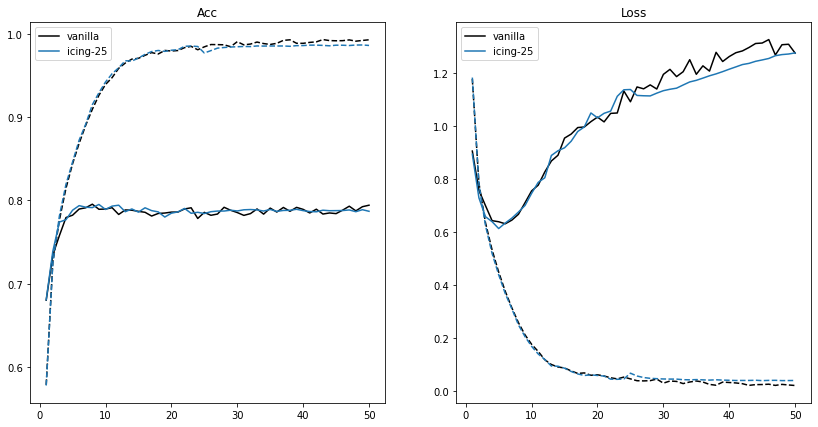

In [8]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Acc')
plt.plot(epochs, hist_dict['acc'], 'k', linestyle='dashed')
plt.plot(epochs, hist_dict['val_acc'], 'k', label='vanilla')
plt.plot(epochs, icing_hist_dict['acc'], 'C0', linestyle='dashed')
plt.plot(epochs, icing_hist_dict['val_acc'], 'C0', label='icing-25')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(epochs, hist_dict['loss'], 'k', linestyle='dashed')
plt.plot(epochs, hist_dict['val_loss'], 'k', label='vanilla')
plt.plot(epochs, icing_hist_dict['loss'], 'C0', linestyle='dashed')
plt.plot(epochs, icing_hist_dict['val_loss'], 'C0', label='icing-25')
plt.legend()

plt.show()